In [1]:
from music21 import *
us = environment.UserSettings()
us['musicxmlPath'] = 'C:\\Program Files\\MuseScore 3\\bin\\MuseScore3.exe'
us['musescoreDirectPNGPath'] = 'C:\\Program Files\\MuseScore 3\\bin\\MuseScore3.exe'
us['musicxmlPath']

WindowsPath('C:/Program Files/MuseScore 3/bin/MuseScore3.exe')

In [9]:
c = converter.parse(r'MAPS\AkPnBcht\MUS\MAPS_MUS-bach_846_AkPnBcht.mid',format='midi')

<music21.graph.plot.HorizontalBarPitchSpaceOffset for <music21.stream.Score 0x2b31dff1c30>>

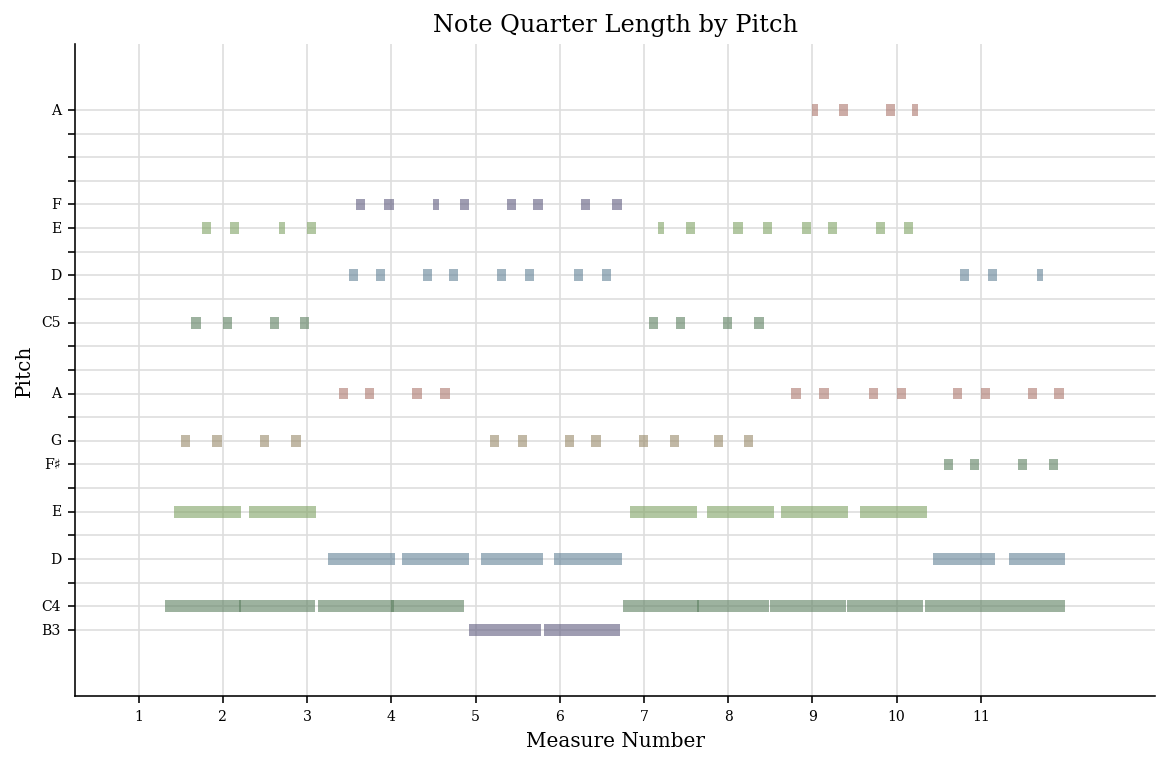

In [3]:
c.measures(1,11).plot("pianoroll")

In [11]:
c.show('text')

{0.0} <music21.metadata.Metadata object at 0x2b321a85c90>
{0.0} <music21.stream.Part 0x2b3230f8430>
    {0.0} <music21.stream.Measure 1 offset=0.0>
        {0.0} <music21.clef.TrebleClef>
        {0.0} <music21.tempo.MetronomeMark Quarter=136.54>
        {0.0} <music21.meter.TimeSignature 4/4>
        {0.0} <music21.stream.Voice 0x2b3230f8520>
            {0.0} <music21.note.Rest 1.25ql>
            {1.25} <music21.note.Note C>
        {0.0} <music21.stream.Voice 0x2b3230f81f0>
            {0.0} <music21.note.Rest 5/3ql>
            {1.6667} <music21.note.Note E>
        {0.0} <music21.stream.Voice 0x2b3230f8640>
            {0.0} <music21.note.Rest half>
            {2.0} <music21.note.Note G>
            {2.5} <music21.note.Note C>
            {3.0} <music21.note.Note E>
            {3.5} <music21.note.Note G>
    {4.0} <music21.stream.Measure 2 offset=4.0>
        {0.0} <music21.stream.Voice 0x2b3230f8940>
            {0.0} <music21.note.Note C>
            {0.5} <music21.note.Rest 

In [56]:
from music21 import tempo

<music21.graph.plot.HistogramPitchSpace for <music21.stream.Score 0x1ee4da821a0>>

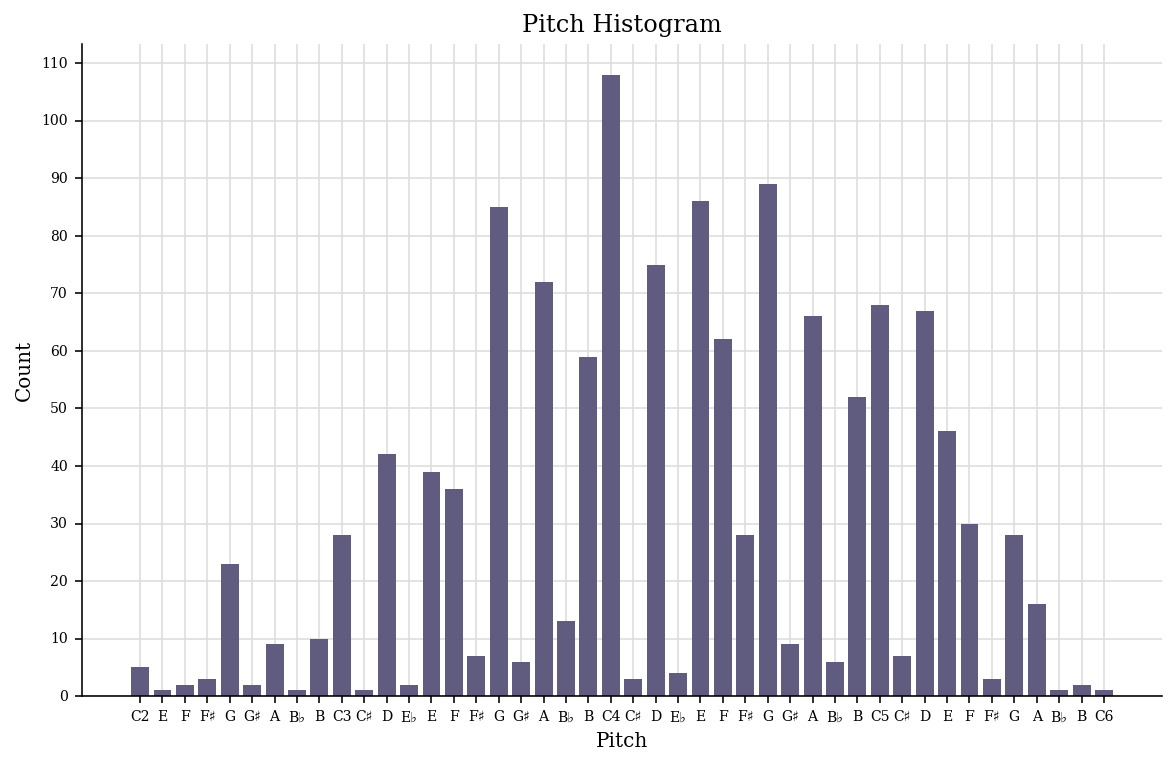

In [30]:
c.plot('histogram', 'pitch')

In [1]:
!pip install --upgrade numpy

  Using cached numpy-1.23.4-cp310-cp310-win_amd64.whl (14.6 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: Could not install packages due to an OSError: [WinError 5] Acceso denegado: 'C:\\Users\\Emmanuel Salazar\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python310\\site-packages\\~~~py\\.libs\\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll'
Check the permissions.



In [32]:
import numpy as np
import torch
x = np.load('Res Base/x_value.npy')
y = np.load('Res Base/y_value.npy')
X_test = np.load('Res Base/X_test_value.npy')

In [2]:
import numpy as np
import torch
x = np.load('Res Fusa/x_value.npy')
y = np.load('Res Fusa/y_value.npy')
X_test = np.load('Res Fusa/X_test_value.npy')

In [33]:
import torch
# Usamos cuda
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [34]:
X=[]
Y=[]
for i in range(x.shape[0]):
    X.append(torch.from_numpy(x[i]).float())
    Y.append(torch.from_numpy(y[i]).float())

In [35]:
from torch.utils.data import Dataset

class NumbersDataset(Dataset):
    def __init__(self):
        self.samples = X
        self.labels = Y

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx], self.labels[idx]

In [36]:
dataset = NumbersDataset()

In [37]:
batch_size = 500
train_loader = torch.utils.data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)

In [38]:
max(x[0])

29.004923

In [3]:
import torch.nn as nn

In [4]:
class create_model(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(252, 500)
        self.BatN1   = nn.BatchNorm1d(500)
        self.linear2 = nn.Linear(500, 250)
        self.BatN2   = nn.BatchNorm1d(250)
        self.linear3 = nn.Linear(250, 88)
        self.Drop   = nn.Dropout(0.3)
        self.ReLU   = nn.ReLU()
        self.Sig     = nn.Sigmoid()
        
        
    def forward(self, x): 
        x = self.linear1(x)
        x = self.ReLU(x)
        x = self.Drop(x)
        x = self.BatN1(x)
        x = self.linear2(x)
        x = self.ReLU(x)
        x = self.Drop(x)
        x = self.BatN2(x)
        x = self.linear3(x)
        x = self.Sig(x)
        return x

In [41]:
def make_train_step(model, loss_fn, optimizer):
    # Construye una función que realiza un paso en el bucle del entrenamiento.
    def train_step(x, y):
        # Pon el modelo en modo entrenamiento
        model.train()
        # Realiza las predicciones
        yhat = model(x)
        # Calcula la perdida
        optimizer.zero_grad()
        loss = loss_fn(yhat, y)
        # Calcula los gradientes
        loss.backward()
        # Actualiza los parametros y haz cero los gradientes
        optimizer.step()
        # Regresa la perdida
        return loss.item()
    
    # Devuelve la función que se llamará dentro del bucle de entrenamiento.
    # Returns the function that will be called inside the train loop
    return train_step

In [ ]:
#Calcular perdida y accuracy de test
def CalcValLossAndAccuracy(model, loss_fn, val_loader):
    with torch.no_grad():
        Y_shuffled, Y_preds, losses = [],[],[]
        for X, Y in tqdm(val_loader):
            X = X.to(device)
            Y = Y.to(device)
            preds = model(X)
            loss = loss_fn(preds, Y)
            losses.append(loss.item())

            Y_shuffled.append(Y)
            Y_preds.append(preds.argmax(dim=-1))
        
        print("Valid Loss : {:.3f}".format(torch.tensor(losses).mean()))
        
        try: 
            Y_preds = torch.cat(Y_preds)
            Y_shuffled = torch.cat(Y_shuffled)
            print("Valid Acc  : {:.3f}".format(accuracy_score(Y_shuffled.detach().cpu().numpy(), Y_preds.detach().cpu().numpy())))
            return(torch.tensor(losses).mean(),accuracy_score(Y_shuffled.detach().cpu().numpy(), Y_preds.detach().cpu().numpy()))
        except: 
            return(torch.tensor(losses).mean(),0)

In [42]:
import torch.optim as optim
import statistics 

In [43]:
# Construye un modelo
model = create_model().to(device)

# Establece los hyper-parametros
lr = 1e-2
n_epochs = 100

# Define la funcion de pertida y optimización
optimizer = optim.Adam(model.parameters(), lr=lr)
loss_fn = nn.BCELoss()

# listas para guardar la perdida
losses_mean = []

# Crea funciones para realizar el paso de entrenamiento del modelo, perdida y optimizador
train_step = make_train_step(model, loss_fn, optimizer)

# Bucle de entrenamiento
for epoch in range(n_epochs):
    # Usa loader para buscar un mini-batch para entrenar
    losses = []
    for x_batch, y_batch in train_loader:
        # AHORA, manda el mini-batch al device
        # en donde coincide con la ubicación del modelo
        x_batch = x_batch.float()
        y_batch = y_batch.float()
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        # Un paso de entrenamiento
        loss = train_step(x_batch, y_batch)
        #Se guarda la perdida
        losses.append(loss)
    #Se calcula el promedio de perdida del Batch
    losses_mean.append(statistics.mean(losses))
    
    # Despues de terminar los pasos de entrenamiento para todos los mini-batches 
    # es tiempo para la evaluación
        
    if (epoch +1) % 1  == 0:
        print(f"[{epoch+1}] Training loss: {statistics.mean(losses):.3f}")

[1] Training loss: 0.058
[2] Training loss: 0.021
[3] Training loss: 0.017
[4] Training loss: 0.015
[5] Training loss: 0.014
[6] Training loss: 0.014
[7] Training loss: 0.013
[8] Training loss: 0.012
[9] Training loss: 0.012
[10] Training loss: 0.011
[11] Training loss: 0.011
[12] Training loss: 0.011
[13] Training loss: 0.010
[14] Training loss: 0.010
[15] Training loss: 0.010
[16] Training loss: 0.010
[17] Training loss: 0.010
[18] Training loss: 0.010
[19] Training loss: 0.009
[20] Training loss: 0.009
[21] Training loss: 0.009
[22] Training loss: 0.009
[23] Training loss: 0.009
[24] Training loss: 0.009
[25] Training loss: 0.009
[26] Training loss: 0.008
[27] Training loss: 0.008
[28] Training loss: 0.008
[29] Training loss: 0.008
[30] Training loss: 0.008
[31] Training loss: 0.008
[32] Training loss: 0.008
[33] Training loss: 0.008
[34] Training loss: 0.008
[35] Training loss: 0.008
[36] Training loss: 0.008
[37] Training loss: 0.008
[38] Training loss: 0.007
[39] Training loss: 0

In [44]:
torch.save(model.state_dict(), 'model')

In [6]:
#Se carga el modelo ya entrenado
model = create_model().to('cpu')
model.load_state_dict(torch.load('Res Fusa/model'))
model.eval()

create_model(
  (linear1): Linear(in_features=252, out_features=500, bias=True)
  (BatN1): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear2): Linear(in_features=500, out_features=250, bias=True)
  (BatN2): BatchNorm1d(250, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear3): Linear(in_features=250, out_features=88, bias=True)
  (Drop): Dropout(p=0.3, inplace=False)
  (ReLU): ReLU()
  (Sig): Sigmoid()
)

In [7]:
X_test = np.load('Res Fusa/X_test_value_norm.npy')

In [8]:
#Se introduce la melodía al modelo
X_test=torch.from_numpy(X_test).float()
yhat = model(X_test)

In [9]:
yhat = yhat.detach().numpy()

In [10]:
Y_pred = 1.0 * ( np.array(yhat) > 0.5)

In [11]:
np.save('Res Fusa/y_hat.npy', Y_pred)

In [45]:
X_testt=torch.from_numpy(X_test).float()
with torch.no_grad():
    model.eval()
    yhat = model(X_testt.to(device)).to('cpu')

In [18]:
np.mean(np.array(yhat))

0.020086825

In [46]:
Y_pred = 1.0 * ( np.array(yhat) > 0.5)
print(Y_pred)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [62]:
X_tt=torch.from_numpy(x).float()
with torch.no_grad():
    model.eval()
    yh = model(X_tt.to(device)).to('cpu')
Y_h = 1.0 * ( np.array(yh) > 0.5)

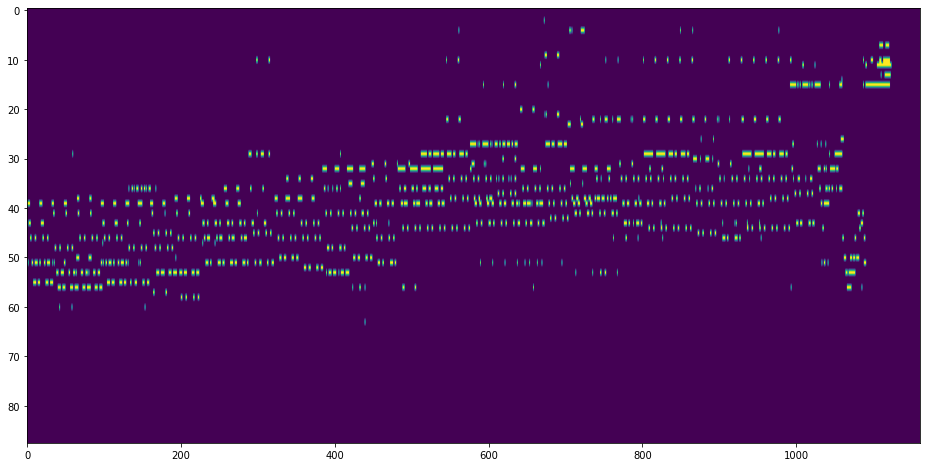

In [12]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16, 8))
plt.imshow(Y_pred.T, aspect="auto")

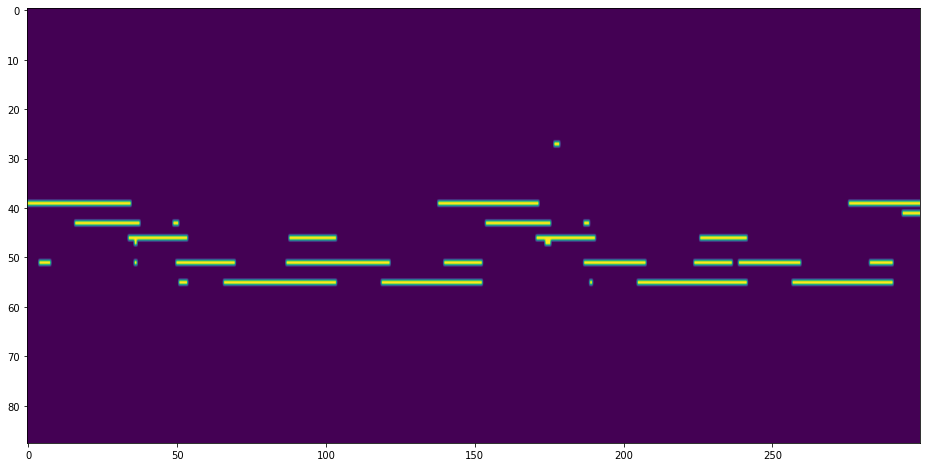

In [54]:
plt.figure(figsize=(16, 8))
plt.imshow((Y_pred[:300].T), aspect="auto")

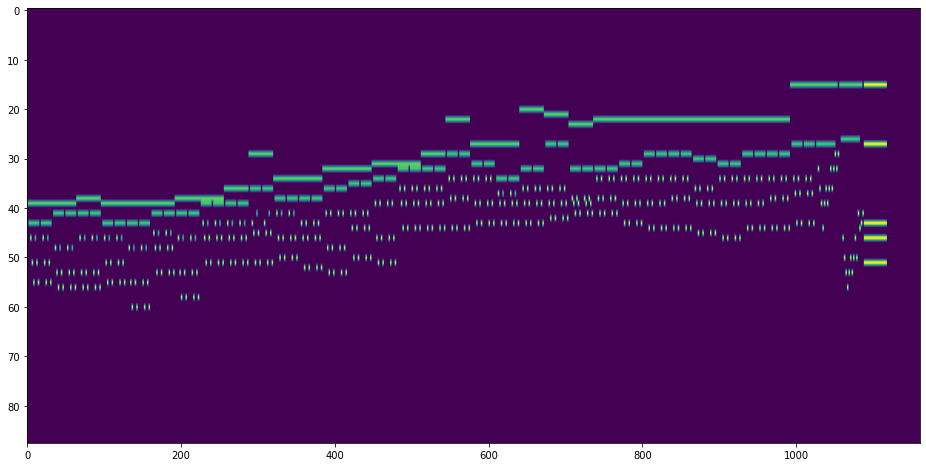

In [67]:
plt.figure(figsize=(16, 8))
plt.imshow(Y_test.T, aspect="auto")

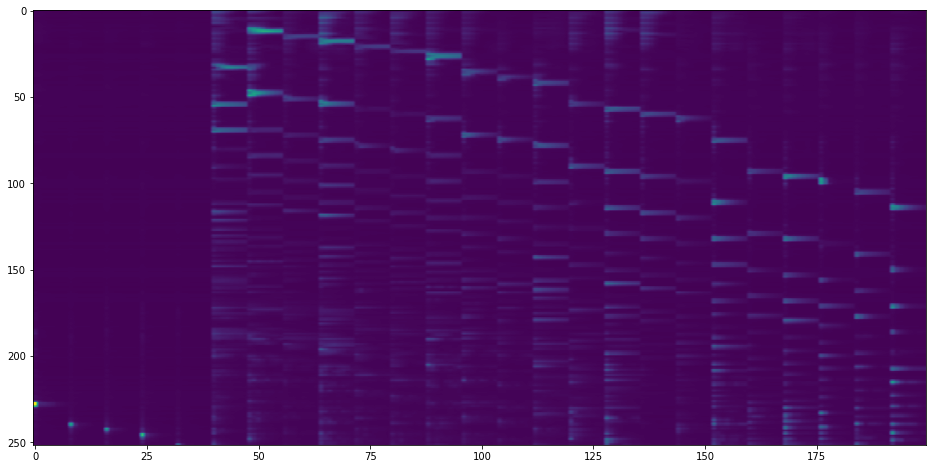

In [28]:
plt.figure(figsize=(16, 8))
plt.imshow(x.T[:, :200], aspect="auto")